In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from google.colab import drive
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

drive.mount('/content/gdrive/')

warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Define path
data_path = '/content/gdrive/My Drive/Breast Cancer/'

# Create DataFrame for each omics data
print("Reading Micro RNA Data")
mirna_data = pd.read_csv(data_path + "BRCA_miRNA.csv", delimiter=",", header=None, skiprows=1)

print("Reading Label Data")
subtype_data = pd.read_csv(data_path + "BRCA_label.csv", delimiter=",", header=None, skiprows=1)

Reading Micro RNA Data
Reading Label Data


In [ ]:
# Ensure all datasets have the same samples
common_samples = list(set.intersection(
    set(mirna_data.index),
    set(subtype_data.index)
))


mirna_data = mirna_data.loc[common_samples]
subtype_data = subtype_data.loc[common_samples]

In [ ]:
# Concatenate the datasets for feature selection
df = pd.concat([mirna_data, subtype_data], axis=1)

In [ ]:
# Drop any non-numeric columns (assuming first column may contain non-numeric identifiers)
features = df.iloc[:, :-1].select_dtypes(include=[np.number])  # Select only numeric columns
target = df.iloc[:, -1]  # All rows, only the last column

In [ ]:
# Scale features by maximum absolute value
max_abs_scaler = MaxAbsScaler()
features = pd.DataFrame(max_abs_scaler.fit_transform(features), columns=features.columns)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.30, train_size=0.70)

In [ ]:
# Set Parameters
C = 1.0
n_features = features.shape[1]

# Create SVM model using a linear kernel
model = svm.SVC(kernel='linear', C=C)

# Use RFE for feature selection
selector = RFE(model, n_features_to_select=190, step=1)
selector = selector.fit(x_train, y_train)

# Get the selected features
selected_features = features.columns[selector.support_]
features = features[selected_features]

print("FINAL FEATURES:")
print(features)

FINAL FEATURES:
          2         3         6         8         12        14        16   \
0   -0.085074 -0.044509  0.362575  0.202698 -0.153803 -0.264026  0.043151   
1   -0.089678 -0.036227  0.364162  0.189253 -0.147843 -0.276255  0.040909   
2   -0.084969 -0.037285  0.365255  0.184583 -0.164854 -0.266045  0.042175   
3    0.118399 -0.283016  0.370200  0.347875  0.172289 -0.074175  0.096026   
4   -0.201900 -0.286587 -0.338192  0.441569  0.232513 -0.286056 -0.033009   
..        ...       ...       ...       ...       ...       ...       ...   
363 -0.233732 -0.143792  0.548299 -0.088601 -0.559269  0.578880  0.598952   
364  0.169141  0.372307  0.120049  0.028403 -0.156759  0.412399  0.110775   
365  0.311230  0.572736 -0.294758 -0.141331 -0.727482  0.236523  0.170246   
366 -0.176978 -0.250437 -0.420373  0.461609  0.387570 -0.323160 -0.012888   
367 -0.424921  0.232551  0.297602  0.038481 -0.320084  0.265260  0.003188   

          17        24        26   ...       637       639 

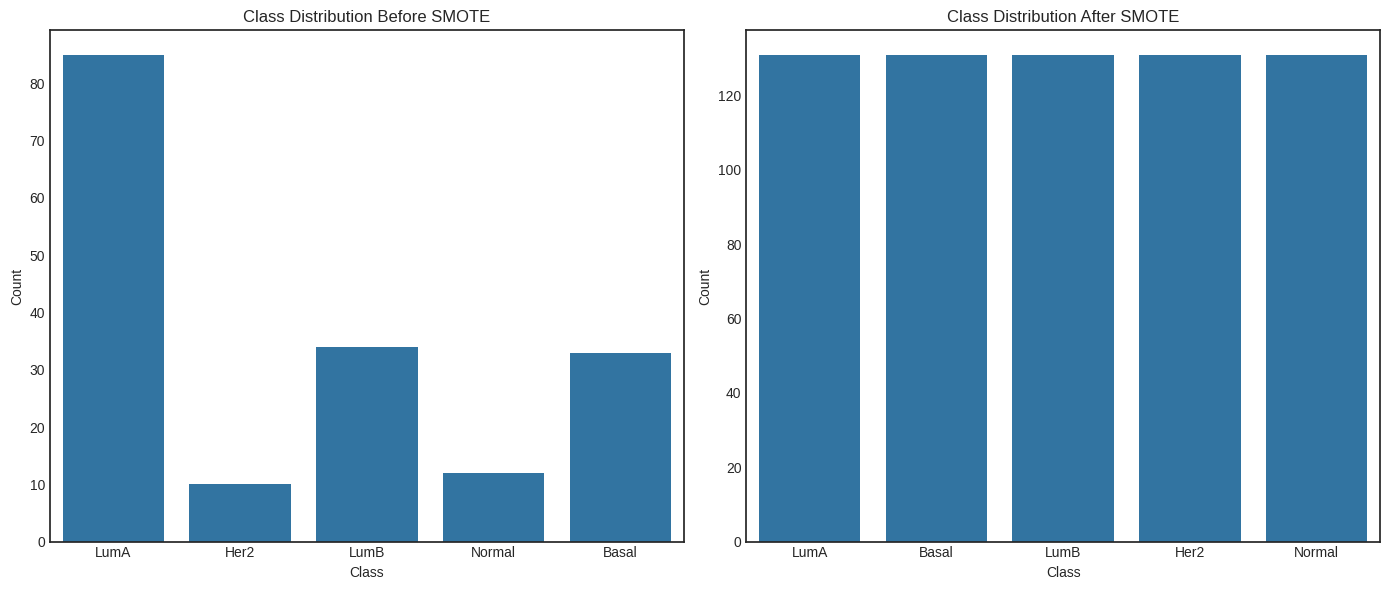

In [ ]:
# Normalize the selected features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the scaled data
x_train, x_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.30, train_size=0.70)

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Convert to DataFrame for better visualization
df_before_smote = pd.DataFrame(x_train, columns=[f'feature_{i}' for i in range(x_train.shape[1])])
df_before_smote['target'] = y_train

df_after_smote = pd.DataFrame(x_train_smote, columns=[f'feature_{i}' for i in range(x_train_smote.shape[1])])
df_after_smote['target'] = y_train_smote

# Plotting the class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
sns.countplot(data=df_before_smote, x='target', ax=axes[0])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After SMOTE
sns.countplot(data=df_after_smote, x='target', ax=axes[1])
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
def specificity_sensitivity_multiclass(cm):
    class_count = cm.shape[0]
    specificity = []
    sensitivity = []

    for i in range(class_count):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]
        specificity.append(tn / (tn + fp))
        sensitivity.append(tp / (tp + fn))

    return np.mean(specificity), np.mean(sensitivity)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

def build_and_evaluate_sdae(x_train, y_train, x_test, y_test, description):
    input_dim = x_train.shape[1]
    input_layer = Input(shape=(input_dim, ))

    # Encoder
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    # Decoder
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder model
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the autoencoder
    history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Extract the encoder part
    encoder = Model(input_layer, encoded)

    # Transform the data with the encoder
    encoded_data_train = encoder.predict(x_train)
    encoded_data_test = encoder.predict(x_test)

    # Build a simple neural network for classification
    classifier_input = Input(shape=(128, ))
    hidden = Dense(64, activation='relu')(classifier_input)
    output = Dense(len(np.unique(y_train)), activation='softmax')(hidden)

    classifier_model = Model(classifier_input, output)
    classifier_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the classifier
    history_classifier = classifier_model.fit(encoded_data_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
    plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate the classifier
    y_pred = classifier_model.predict(encoded_data_test).argmax(axis=1)
    loss, accuracy = classifier_model.evaluate(encoded_data_test, y_test, verbose=0)

    print(f'Accuracy {description} (SDAE): {accuracy * 100:.2f}%')

    # Calculate additional metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    specificity, sensitivity = specificity_sensitivity_multiclass(cm)

    print(f'Precision {description} (SDAE): {precision:.2f}')
    print(f'Recall {description} (SDAE): {recall:.2f}')
    print(f'F1 Score {description} (SDAE): {f1:.2f}')
    print(f'Specificity {description} (SDAE): {specificity:.2f}')
    print(f'Sensitivity {description} (SDAE): {sensitivity:.2f}')

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=np.unique(y_test))

In [ ]:
def build_and_evaluate_dbn(x_train, y_train, x_test, y_test, description):
    input_dim = x_train.shape[1]
    dbn_input = Input(shape=(input_dim, ))
    hidden = Dense(64, activation='relu')(dbn_input)
    output = Dense(len(np.unique(y_train)), activation='softmax')(hidden)

    dbn_model = Model(dbn_input, output)
    dbn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the DBN
    history = dbn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the DBN
    y_pred = dbn_model.predict(x_test).argmax(axis=1)
    loss, accuracy = dbn_model.evaluate(x_test, y_test, verbose=0)

    print(f'Accuracy {description} (DBN): {accuracy * 100:.2f}%')

    # Calculate additional metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    specificity, sensitivity = specificity_sensitivity_multiclass(cm)

    print(f'Precision {description} (DBN): {precision:.2f}')
    print(f'Recall {description} (DBN): {recall:.2f}')
    print(f'F1 Score {description} (DBN): {f1:.2f}')
    print(f'Specificity {description} (DBN): {specificity:.2f}')
    print(f'Sensitivity {description} (DBN): {sensitivity:.2f}')

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=np.unique(y_test))


In [ ]:
def check_and_convert_data(x_train, y_train, x_test, y_test):
    print("Data Types Before Conversion:")
    print(f"x_train: {x_train.dtype}")
    print(f"y_train: {y_train.dtype}")
    print(f"x_test: {x_test.dtype}")
    print(f"y_test: {y_test.dtype}")

    # Convert to numeric types if necessary
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)

    # Encode labels if they are of object type
    if y_train.dtype == 'object':
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
    if y_test.dtype == 'object':
        y_test = label_encoder.transform(y_test)

    print("Data Types After Conversion:")
    print(f"x_train: {x_train.dtype}")
    print(f"y_train: {y_train.dtype}")
    print(f"x_test: {x_test.dtype}")
    print(f"y_test: {y_test.dtype}")

    return x_train, y_train, x_test, y_test

# Assuming x_train, y_train, x_test, y_test, x_train_smote, y_train_smote are your datasets
x_train, y_train, x_test, y_test = check_and_convert_data(x_train, y_train, x_test, y_test)
x_train_smote, y_train_smote, _, _ = check_and_convert_data(x_train_smote, y_train_smote, x_test, y_test)


Data Types Before Conversion:
x_train: float64
y_train: object
x_test: float64
y_test: object
Data Types After Conversion:
x_train: float32
y_train: int64
x_test: float32
y_test: int64
Data Types Before Conversion:
x_train: float64
y_train: object
x_test: float32
y_test: int64
Data Types After Conversion:
x_train: float32
y_train: int64
x_test: float32
y_test: int64


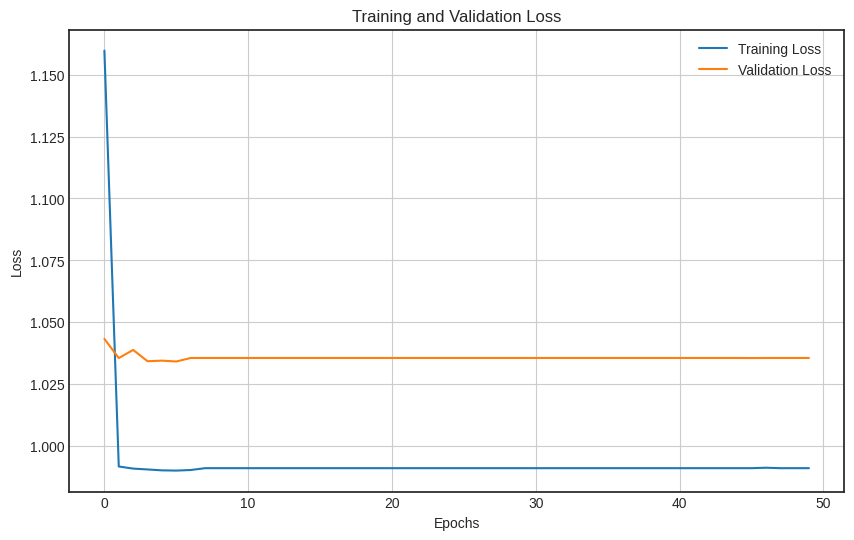

4/4 [==============================] - 0s 6ms/step


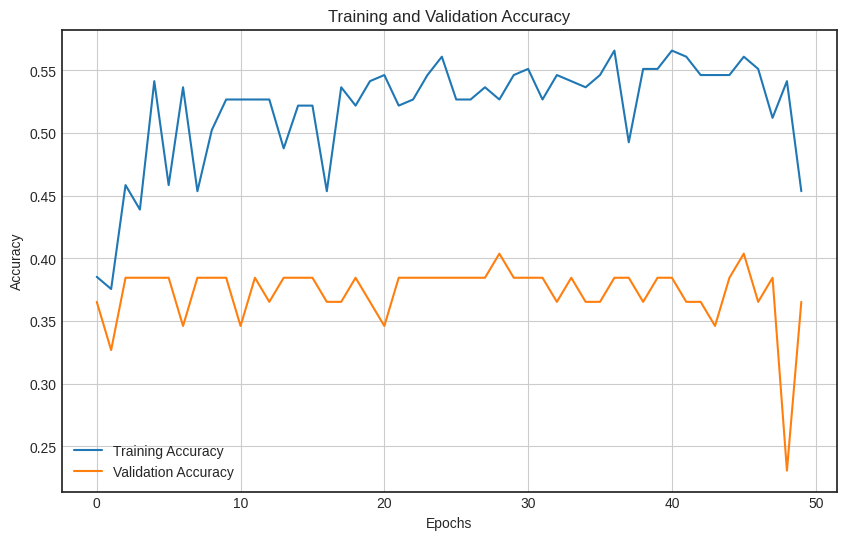

4/4 [==============================] - 0s 5ms/step
Accuracy without SMOTE (SDAE): 54.95%
Precision without SMOTE (SDAE): 0.37
Recall without SMOTE (SDAE): 0.55
F1 Score without SMOTE (SDAE): 0.41
Specificity without SMOTE (SDAE): 0.81
Sensitivity without SMOTE (SDAE): 0.22


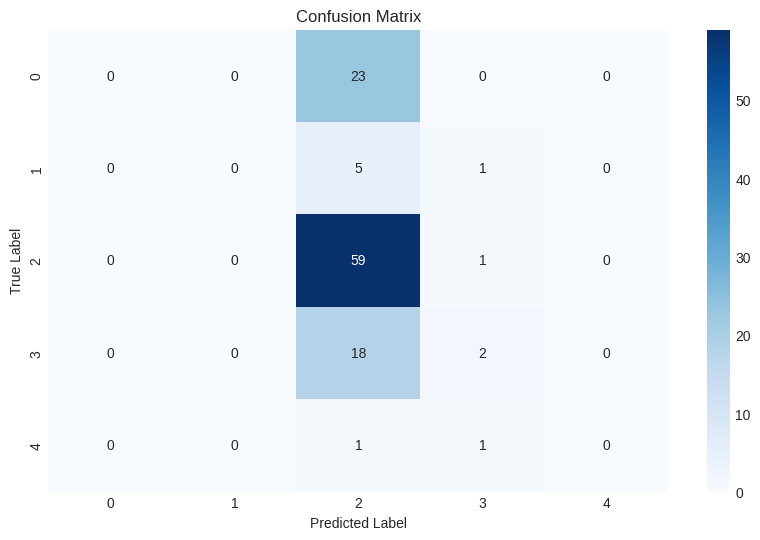

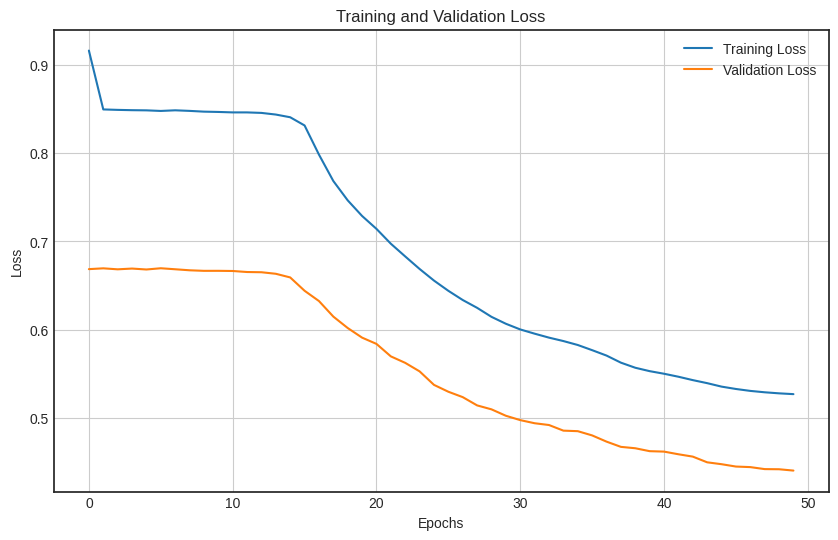

4/4 [==============================] - 0s 5ms/step


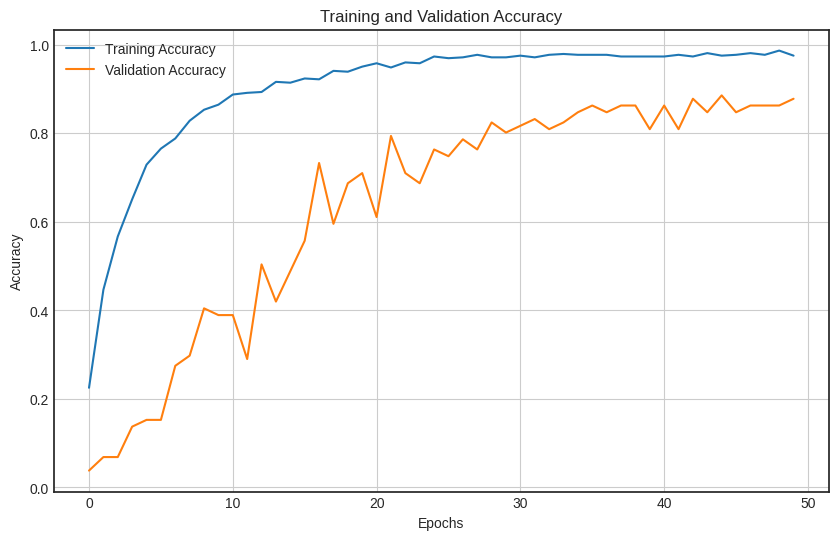

4/4 [==============================] - 0s 4ms/step
Accuracy with SMOTE (SDAE): 39.64%
Precision with SMOTE (SDAE): 0.40
Recall with SMOTE (SDAE): 0.40
F1 Score with SMOTE (SDAE): 0.39
Specificity with SMOTE (SDAE): 0.81
Sensitivity with SMOTE (SDAE): 0.22


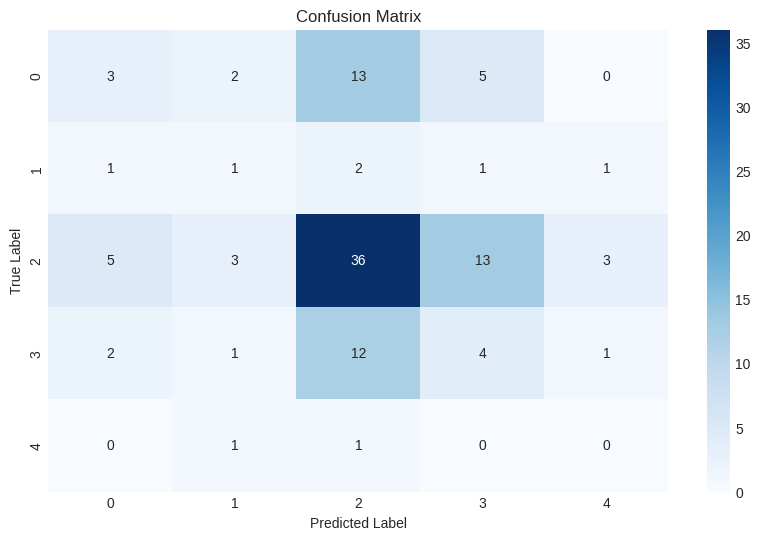

4/4 [==============================] - 0s 3ms/step
Accuracy without SMOTE (DBN): 44.14%
Precision without SMOTE (DBN): 0.42
Recall without SMOTE (DBN): 0.44
F1 Score without SMOTE (DBN): 0.43
Specificity without SMOTE (DBN): 0.82
Sensitivity without SMOTE (DBN): 0.22


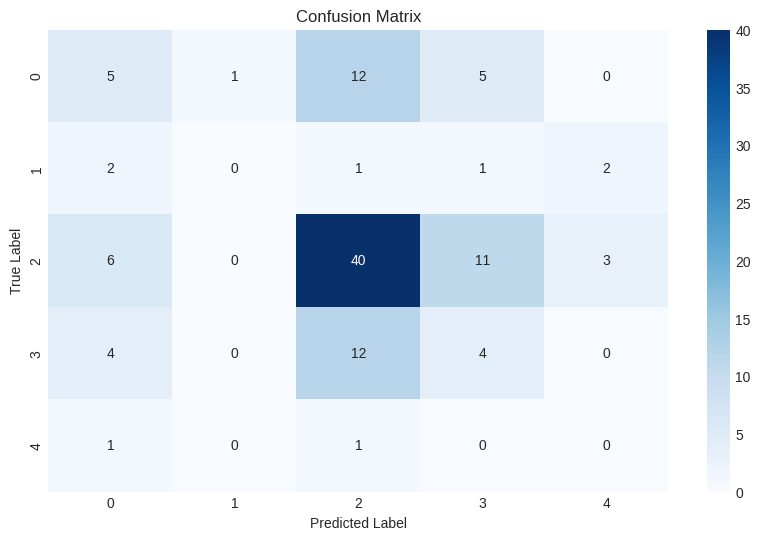

4/4 [==============================] - 0s 3ms/step
Accuracy with SMOTE (DBN): 40.54%
Precision with SMOTE (DBN): 0.37
Recall with SMOTE (DBN): 0.41
F1 Score with SMOTE (DBN): 0.38
Specificity with SMOTE (DBN): 0.80
Sensitivity with SMOTE (DBN): 0.18


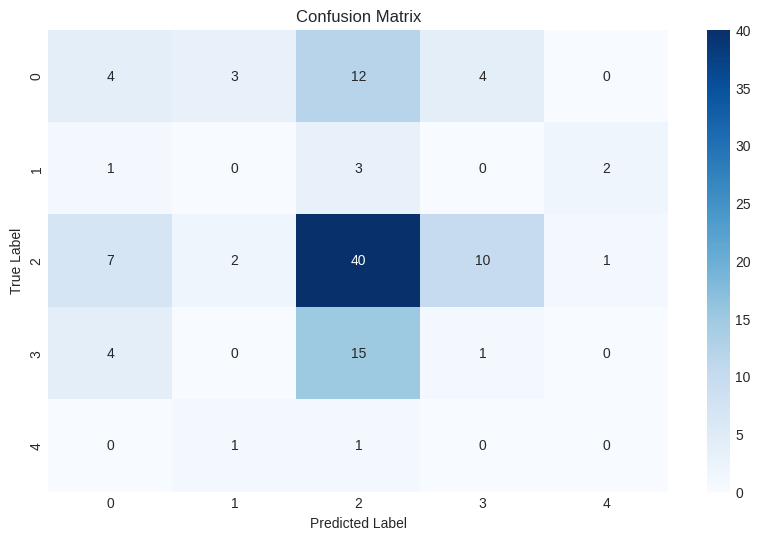

In [ ]:
# Evaluate SDAE without SMOTE
build_and_evaluate_sdae(x_train, y_train, x_test, y_test, "without SMOTE")

# Evaluate SDAE with SMOTE
build_and_evaluate_sdae(x_train_smote, y_train_smote, x_test, y_test, "with SMOTE")

# Evaluate DBN without SMOTE
build_and_evaluate_dbn(x_train, y_train, x_test, y_test, "without SMOTE")

# Evaluate DBN with SMOTE
build_and_evaluate_dbn(x_train_smote, y_train_smote, x_test, y_test, "with SMOTE")

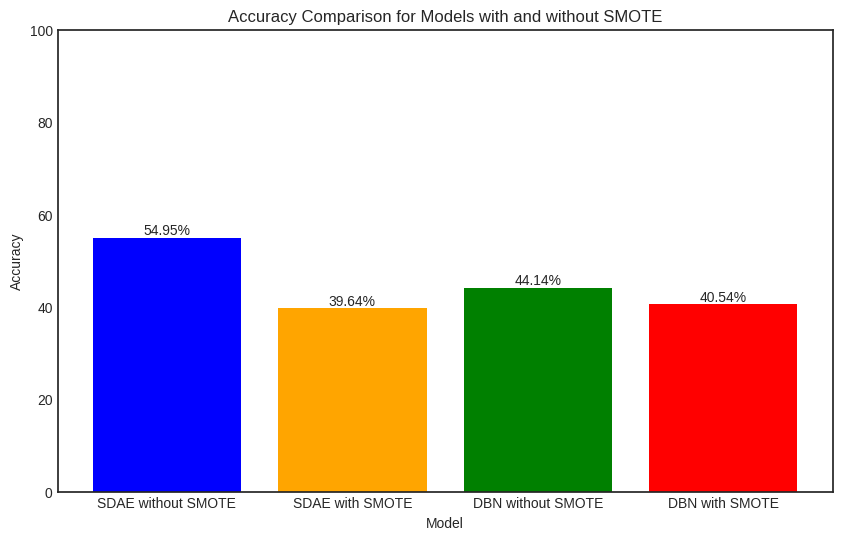

In [ ]:
# Accuracy results
models = ['SDAE without SMOTE', 'SDAE with SMOTE', 'DBN without SMOTE', 'DBN with SMOTE']
accuracy = [54.95, 39.64, 44.14, 40.54]

# Function to plot metrics
def plot_metrics(models, values, metric_name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, values, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison for Models with and without SMOTE')
    plt.ylim(0, 100)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
    plt.show()

# Plotting the accuracy
plot_metrics(models, accuracy, 'Accuracy')